In [99]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pointbiserialr, chisquare

In [100]:
# Read data into pandas
data = pd.read_csv("./loan_data.csv")
data.head()

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0


In [101]:
# Use onehot-encoding to deal with "purpose" column

y = pd.get_dummies(data.purpose, prefix="purpose")
for column in y.columns:
    data[column] = y[column]

del data["purpose"]

# grab target "not.fully.paid" column
target = data["not.fully.paid"]
del data["not.fully.paid"]

data.head()

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,purpose_all_other,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_major_purchase,purpose_small_business
0,1,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0,0,1,0,0,0,0
1,1,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0,1,0,0,0,0,0
2,1,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0,0,1,0,0,0,0
3,1,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0,0,1,0,0,0,0
4,1,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0,1,0,0,0,0,0


In [102]:
## Training the Model

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Run the model with various inputs and segmentation to find the best model

best_score = 0
best_model = None
best_n_trees = 10
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2)
    for trees in range(10, 30, 5):
        model = RandomForestClassifier(n_estimators=trees)
        model.fit(X_train, y_train)
        
        # Compare model against previous best
        cur_score = model.score(X_test, y_test)
        if cur_score > best_score:
            best_score = cur_score
            best_model = model
            best_n_trees = trees
            
print(best_score)


0.849164926931


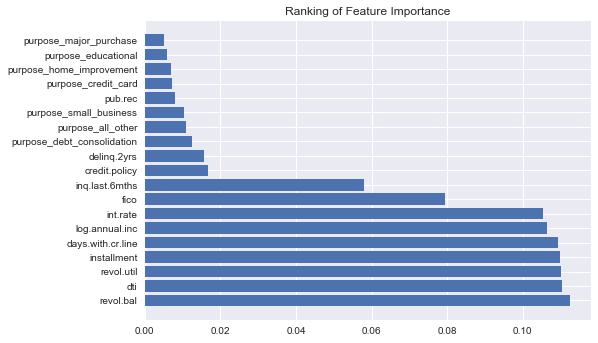

In [103]:
ranking = best_model.feature_importances_
indices = np.argsort(best_model.feature_importances_)[::-1]
plt.barh(range(1, 20), ranking[indices], align="center")
plt.yticks(range(1, 20), data.columns[data.columns != "not.fully.paid"][indices])
plt.title("Ranking of Feature Importance")
plt.show()

In [104]:
## Question 2 

In [105]:
# return data frame to original form 

data['not.fully.paid'] = target 
data.head()

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,purpose_all_other,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_major_purchase,purpose_small_business,not.fully.paid
0,1,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0,0,1,0,0,0,0,0
1,1,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0,1,0,0,0,0,0,0
2,1,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0,0,1,0,0,0,0,0
3,1,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0,0,1,0,0,0,0,0
4,1,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0,1,0,0,0,0,0,0


In [110]:
# Segment Data 
paid_data = data[data["not.fully.paid"] == 0]
unpaid_data = data[data["not.fully.paid"] == 1]

# segment further into discrete and continuous features

paid_cont_data = paid_data[paid_data.columns[1: 12]]
paid_disc_data = paid_data[paid_data.columns[12:-1]]
paid_disc_data["credit.policy"] = paid_data[paid_data.columns[0]]

unpaid_cont_data = unpaid_data[unpaid_data.columns[1: 12]]
unpaid_disc_data = unpaid_data[unpaid_data.columns[12:-1]]
unpaid_disc_data["credit.policy"] = unpaid_data[unpaid_data.columns[0]]

# ignore error im not bothering to fix this LOL


/Users/alexyoung/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/alexyoung/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


,purpose_all_other,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_major_purchase,purpose_small_business,credit.policy
0,0,0,1,0,0,0,0,1
1,0,1,0,0,0,0,0,1
2,0,0,1,0,0,0,0,1
3,0,0,1,0,0,0,0,1
4,0,1,0,0,0,0,0,1


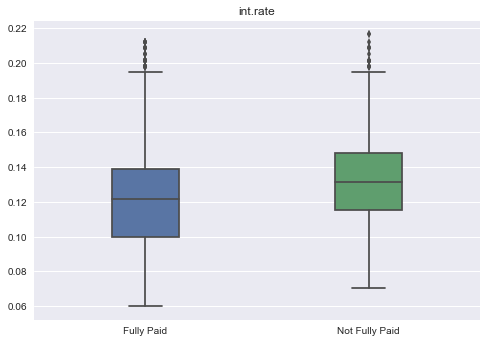

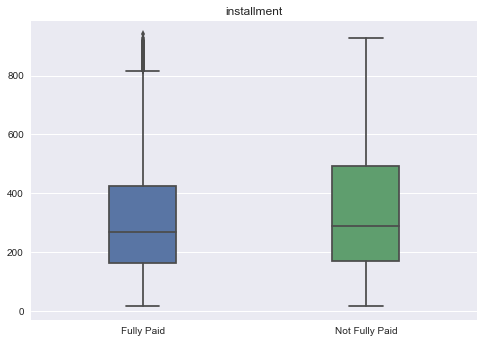

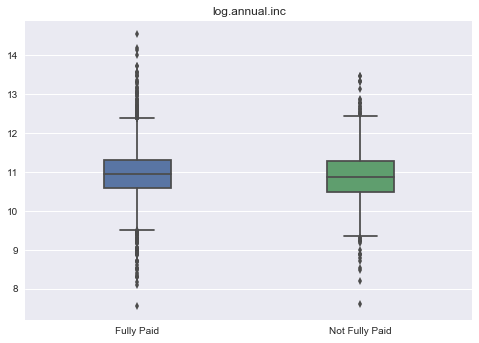

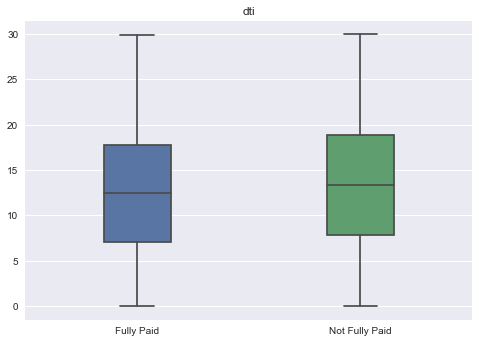

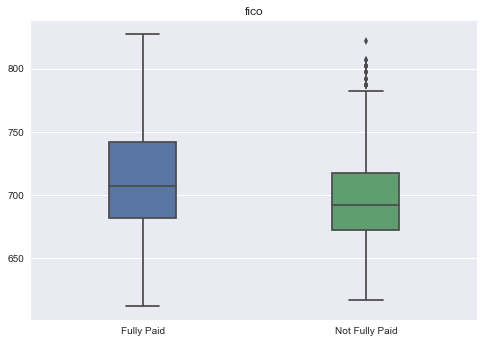

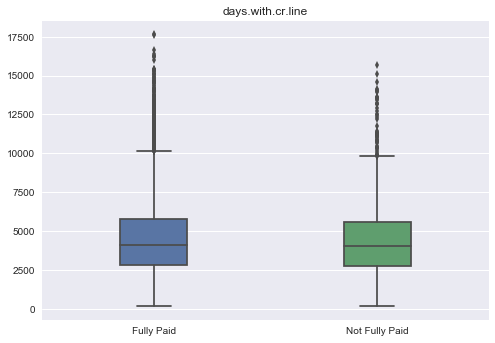

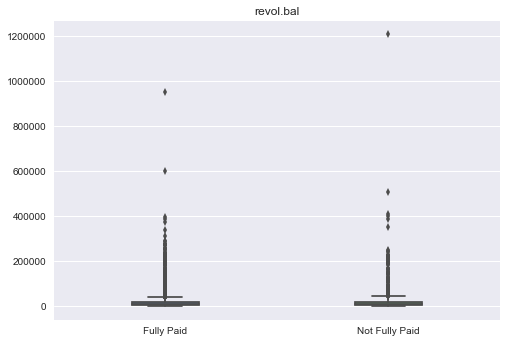

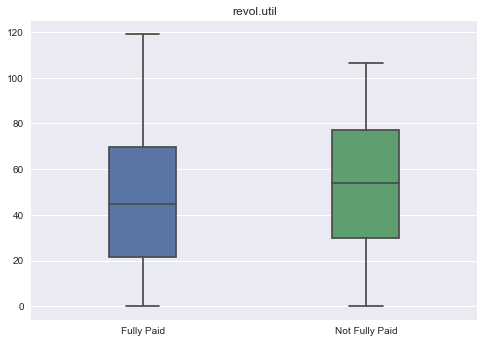

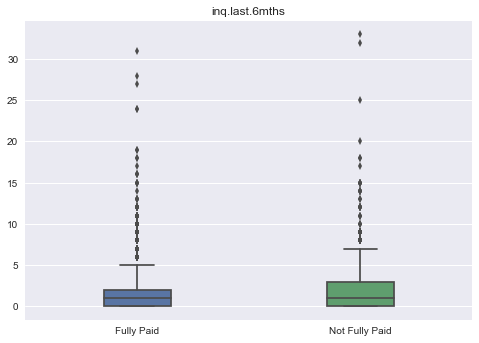

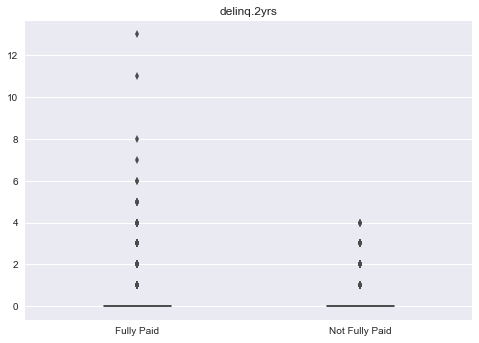

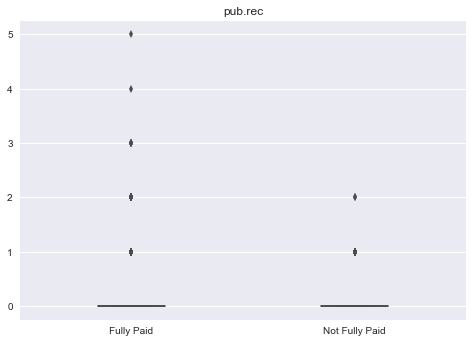

In [111]:
# Create boxplots from all continuous data 

for i in range(len(unpaid_cont_data.columns)):
    name = paid_cont_data.columns[i]
    paid = paid_cont_data[paid_cont_data.columns[i]]
    unpaid = unpaid_cont_data[unpaid_cont_data.columns[i]]
    data = pd.DataFrame({"Fully Paid": paid, "Not Fully Paid": unpaid})
    sn.boxplot(data=data, width=.3)
    plt.title(name)
    plt.show()


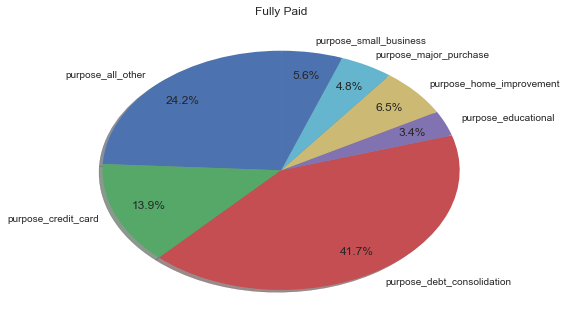

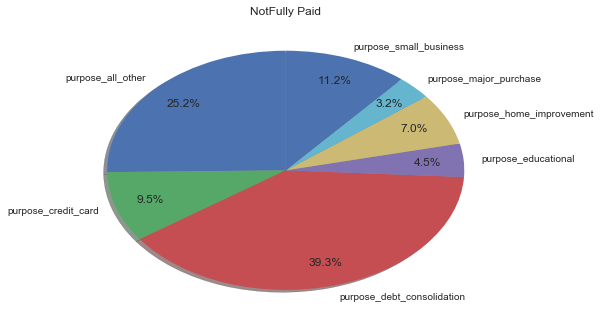

In [172]:
# Create pie chart for categorical variables (excluding credit policy)
total = len(paid_disc_data)

labels = []
sizes = []
for i in range(len(paid_disc_data.columns)-1):
    name = paid_disc_data.columns[i]
    labels.append(name)
    size = paid_disc_data[paid_disc_data.columns[i]].sum()/total * 100
    sizes.append(size)
    
plt.pie(sizes, labels=labels,autopct='%1.1f%%',
        shadow=True, pctdistance=.8, startangle=90)
plt.title("Fully Paid")
plt.show()

labels = []
sizes = []
for i in range(len(unpaid_disc_data.columns)-1):
    name = unpaid_disc_data.columns[i]
    labels.append(name)
    size = unpaid_disc_data[unpaid_disc_data.columns[i]].sum()/total * 100
    sizes.append(size)
    
plt.pie(sizes, labels=labels,autopct='%1.1f%%',
        shadow=True, pctdistance=.8, startangle=90)
plt.title("Not Fully Paid")
plt.show()
